<a href="https://colab.research.google.com/github/ParkSlingshot/-/blob/main/Find_CarPlate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [21]:
import cv2 as cv
import IPython 
import numpy as np
from google.colab.patches import cv_imshow

In [65]:
from google.colab import files
files.upload()

Saving 1.jpg to 1.jpg


{'1.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x13\x13\x12\x15\x13\x13\x13\x16\x15\x15\x16\x18\x19\x18\x17\x18\x18\x18\x1f\x18\x18\x1b\x1a\x1d\x1e\x1b\x1b\x1a\x1d\x1a\x1d\x1d\x1f( \x18\x1d%\x1d\x19\x1b!1!%)+...\x1d\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1b\x10\x10\x1a-%\x1f%-------5---------------------------/------/------5\xff\xc0\x00\x11\x08\x00\xc2\x01\x03\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x01\x05\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x00\x02\x03\x04\x06\x01\x07\x08\xff\xc4\x00R\x10\x00\x01\x01\x03\x08\x05\x07\x08\x05\x08\x08\x06\x03\x00\x00\x00\x01\x02\x00\x03\x11\x04\x05\x12!1AQ\xf0\x06aq\x81\x91\x13"R\xa1\xb1\xc1\xd1\x14\x152Sb\x92\xe1\xf1\x07#Br\x82\x16\x183e\x93\xa4\xd2\xe3\x17CDT\x94\xa2\xc2\xe2\x08$4Us\xb2Ec\x84\xff\xc4\x00\x18\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\xff\xc4\x00*\x11\x01\x00\x02\x01\x02\x04\x05\x04\x03\x01\x00

In [66]:
weight = '/content/gdrive/MyDrive/yolo/yolov3.weights'
names = '/content/gdrive/MyDrive/yolo/coco.names'
cgf = '/content/gdrive/MyDrive/yolo/yolov3.cfg'
img = '1.jpg'

In [37]:
classes = []
with open(names, 'r') as f:
  classes = [line.strip() for line in f.readlines()] 

In [38]:
min = 0.5
colors = np.random.uniform(0,255, size=(len(classes)))

In [40]:
 net = cv.dnn.readNet(weight, cgf)
 layer_names = net.getLayerNames()
 output_layers = [layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()]

#Plate

In [48]:
plate_cascade_name = '/content/gdrive/MyDrive/yolo/haarcascade_russian_plate_number.xml'
plate_cascade = cv.CascadeClassifier(plate_cascade_name)
  

0 2 car


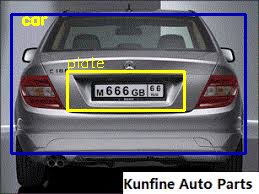

In [71]:
image = cv.imread(img)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
gray = cv.equalizeHist(gray)
height, width, channel = image.shape

boxes, confidences, class_ids = [],[],[]
plate = 'plate'

blob = cv.dnn.blobFromImage(image, 0.00392, (416,416), (0,0,0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

for out in outs:
  for detection in out:
    scores = detection[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    if confidence > min :
      centerx = int(detection[0]*width)
      centery = int(detection[1]*height)
      #yolo의 좌표는 상대값으로 0~1의 값으로 표현
      w = int(detection[2]*width)
      h = int(detection[3]*height)
      x = int(centerx-w /2)
      y = int(centery-h /2)
      boxes.append([x,y,w,h])
      confidences.append(float(confidence))
      class_ids.append(class_id)

indexes = cv.dnn.NMSBoxes(boxes, confidences, min, 0.4)
font = cv.FONT_HERSHEY_SIMPLEX

for i in range(len(boxes)):
  if i in indexes:
    if class_ids[i] == 2:
        x,y,w,h = boxes[i]
        color = colors[i]
        label = str(classes[class_ids[i]])
        print(i, class_ids[i], label)
        cv.rectangle(image, (x,y), (x+w, y+h), color, 2)
        cv.putText(image, label, (x+10, y+10), font, 0.5, (0,255,255), 2)
        carROI = gray[y:y+h, x:x+w]
        plates = plate_cascade.detectMultiScale(carROI)
        for (x2, y2, w2, h2) in plates:
          cv.rectangle(image, (x+x2,y+y2), (x+x2+w2, y+y2+h2), (0,255,255), 2)
          cv.putText(image, plate, (x2+10,y2+10), font, 0.5, (0,255,255), 1)

cv_imshow(image)